In [1]:
%matplotlib inline
import numpy as np
import random
import time
from scipy import fftpack
import os, sys
import pandas as pd
import scipy.ndimage as ndimage
import healpy as hp
from astropy.io import fits
from importlib import reload 

import matplotlib.pyplot as plt

# sys path prepend and reload are for development
sys.path = ['../'] + sys.path
print(sys.path)

['../', '', '/Users/ucapnje/anaconda3/lib/python36.zip', '/Users/ucapnje/anaconda3/lib/python3.6', '/Users/ucapnje/anaconda3/lib/python3.6/lib-dynload', '/Users/ucapnje/.local/lib/python3.6/site-packages', '/Users/ucapnje/anaconda3/lib/python3.6/site-packages', '/Users/ucapnje/anaconda3/lib/python3.6/site-packages/aeosa', '/Users/ucapnje/anaconda3/lib/python3.6/site-packages/pydelfi-0.1-py3.6.egg', '/Users/ucapnje/anaconda3/lib/python3.6/site-packages/deepmass-0.1-py3.6.egg', '/Users/ucapnje/anaconda3/lib/python3.6/site-packages/IPython/extensions', '/Users/ucapnje/.ipython']


In [2]:
# sys path prepend and reload are for development

from deepmass import map_functions as mf
from deepmass import lens_data as ld

reload(mf)
reload(ld)

<module 'deepmass.lens_data' from '../deepmass/lens_data.py'>

In [3]:


def kaiser_squires_square_maps(g1, g2):
    
    size = len(g1)
    
    g1_ft = fftpack.fft2(g1)
    g2_ft = fftpack.fft2(g2)
    
    k_modes = fftpack.fftfreq(size)
    
    k1_grid = np.dstack(np.meshgrid(k_modes, k_modes))[:,:,0]
    k2_grid = k1_grid.T # k2 are transpose of k1 for square maps
    
    k1_squared = k1_grid**2
    k2_squared = k2_grid**2
    k_squared = k1_squared + k2_squared

    k_squared[k_squared==0] = 1e-18
    
    kappaE_ft = (g1_ft/k_squared)*(k1_squared-k2_squared) + (g2_ft/k_squared)*2*(k1_grid*k2_grid)
    kappaB_ft = (-1.0*g1_ft/k_squared)*2.0*(k1_squared*k2_squared) + (g2_ft/k_squared)*(k1_squared-k2_squared)

    return fftpack.ifft2(kappaE_ft).real, fftpack.ifft2(kappaB_ft).real




# function to compute the power spectrum of a 2d image
def radial_profile(data):
    center = data.shape[0]/2
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center)**2 + (y - center)**2)
    r = r.astype(np.int)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile / data.shape[0]**2


def compute_spectrum_map(Px,size):
    """
    takes 1D power spectrum and makes it an isotropic 2D map
    """
    power_map = np.zeros((size, size), dtype = float)
    k_map =  np.zeros((size, size), dtype = float)

    for (i,j), val in np.ndenumerate(power_map):

        k1 = i - size/2.0
        k2 = j - size/2.0
        k_map[i, j] = (np.sqrt(k1*k1 + k2*k2))

        if k_map[i,j]==0:
            #print(i,j)
            power_map[i, j] = 1e-15
        else:
            #print(k_map[i, j])
            power_map[i, j] = Px[int(k_map[i, j])]
    return power_map


# define the kappa to shear operator
def H_operator(ka_map, kb_map):
    
    # ka_map and kb_map should be of the same size
    [nx,ny] = ka_map.shape
    
    ka_map_fft = np.fft.fft2(ka_map)
    kb_map_fft = np.fft.fft2(kb_map)
    
    f1, f2 = np.meshgrid(np.fft.fftfreq(ny),np.fft.fftfreq(nx))
    
    p1 = f1 * f1 - f2 * f2
    p2 = 2 * f1 * f2
    f2 = f1 * f1 + f2 * f2
    f2[0,0] = 1 # avoid division with zero
    kafc =  (p1 * ka_map_fft - p2 * kb_map_fft) / f2
    kbfc =  (p1 * kb_map_fft + p2 * ka_map_fft) / f2
    
    g1_map = np.fft.ifft2(kafc).real
    g2_map = np.fft.ifft2(kbfc).real
    
    return g1_map, g2_map


# define the shear to convergence operator
def H_adjoint(g1_map, g2_map):
    
    [nx,ny] = g1_map.shape
    
    g1_map_ifft = np.fft.ifft2(g1_map)
    g2_map_ifft = np.fft.ifft2(g2_map)
    
    f1, f2 = np.meshgrid(np.fft.fftfreq(ny),np.fft.fftfreq(nx))
    
    p1 = f1 * f1 - f2 * f2
    p2 = 2 * f1 * f2
    f2 = f1 * f1 + f2 * f2
    f2[0,0] = 1
    g1fc =  (p1 * g1_map_ifft + p2 * g2_map_ifft) / f2
    g2fc =  (p1 * g2_map_ifft - p2 * g1_map_ifft) / f2
    
    kappa1 = np.fft.fft2(g1fc).real
    kappa2 = np.fft.fft2(g2fc).real
    
    return kappa1, kappa2




    
def prox_wiener_filtering(gamma1, gamma2, Px_map, Ncov, n_iter = 500):
        
    # initiallize
    nx = gamma1.shape[0]
    xg = np.zeros((nx,nx)) + 1j * np.zeros((nx,nx))
    
    # find the minimum noise variance
    tau = np.min(Ncov)
    
    # set the step size
    eta = 1.83 * tau
    
    # compute signal coefficient
    Esn = eta / Ncov
    
    # calculate the wiener filter coefficients
    Wfc = Px_map / (Px_map + eta)
    
    for n in range(n_iter):
        t1,t2 = H_operator(xg.real, xg.imag)                              # H * xg
        t1,t2 = H_adjoint(Esn*(gamma1 - t1), Esn*(gamma2 - t2))           # H^T(eta / Sn * (y- H * xg))
        t = xg + (t1 + 1j*t2)                                             # xg + H^T(eta / Sn * (y- H * xg))
        
        tf = np.fft.fftshift(np.fft.fft2(t))
        xgf = Wfc * tf                                                    # wiener filtering in fourier space
        xg = np.fft.ifft2(np.fft.fftshift(xgf))
        
    return xg.real, xg.imag
    

In [4]:
picola_example = hp.read_map('../picola_training/kappaC_rescaled.fits', verbose=False)

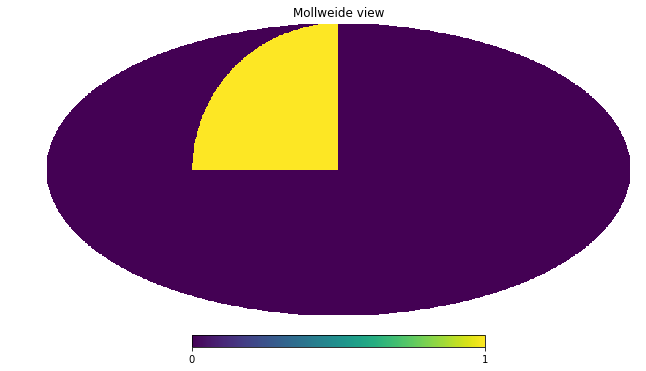

In [5]:
reduced_nside = 1024

msk=np.zeros(hp.nside2npix(reduced_nside))
th,ph=hp.pix2ang(reduced_nside,np.arange(hp.nside2npix(reduced_nside)))
ph[np.where(ph>np.pi)[0]]-=2*np.pi
msk[np.where((th<np.pi*0.5) & (ph>0) & (ph<np.pi*0.5))[0]]=1.
hp.mollview(msk)

In [6]:
picola_example_masked = np.where(msk>0.5, picola_example, hp.UNSEEN)

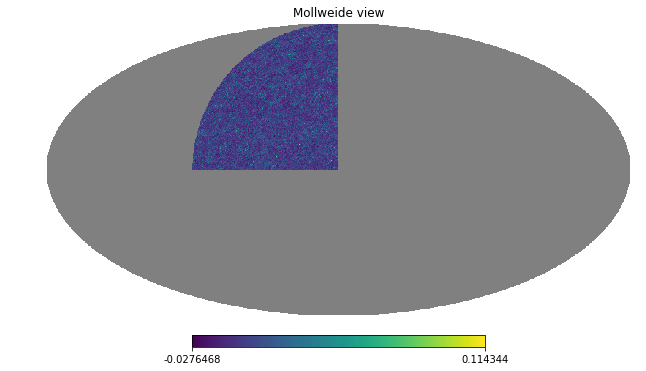

In [7]:
hp.mollview(picola_example_masked)

In [9]:
patch = ld.random_map(picola_example_masked)

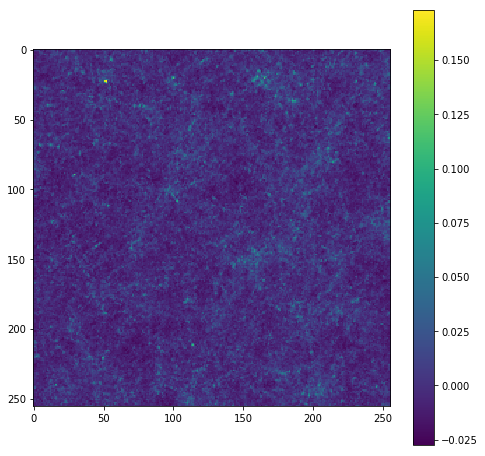

In [10]:
_ =plt.figure(figsize=(8,8)), plt.imshow(patch), plt.colorbar()

# Convert to e1 and e2

In [11]:
k_modes = fftpack.fftfreq(patch.shape[0])
k1_grid = np.dstack(np.meshgrid(k_modes, k_modes))[:,:,0]
k2_grid = k1_grid.T 

k1_vector = np.reshape(k1_grid, -1)
k2_vector = np.reshape(k2_grid, -1)

k_squared = k1_vector*k1_vector + k2_vector*k2_vector
k_squared2 = np.where(k_squared==0, 1e-18, k_squared)

A_inverse_ft_diagonal = (k1_vector**2 - k2_vector**2 - 1j*2.0*k1_vector*k2_vector)/k_squared2
A_inverse_ft_diagonal = np.where(k_squared!=0.0, A_inverse_ft_diagonal, 1.0)

A_ft_diagonal = (k1_vector**2 - k2_vector**2 + 1j*2.0*k1_vector*k2_vector)/k_squared2
A_ft_diagonal = np.where(k_squared!=0.0, A_ft_diagonal, 1.0)

In [12]:
shear_ft = A_ft_diagonal * (np.fft.fft2(patch).flatten())

shear = np.fft.ifft2(np.reshape(shear_ft, patch.shape))

g1 = shear.real
g2 = shear.imag

patch_test = np.fft.ifft2(np.reshape(A_inverse_ft_diagonal * shear_ft, patch.shape))

patch_test2 = kaiser_squires_square_maps(g1, g2) # old & different KS numerical implementation



/Users/ucapnje/anaconda3/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


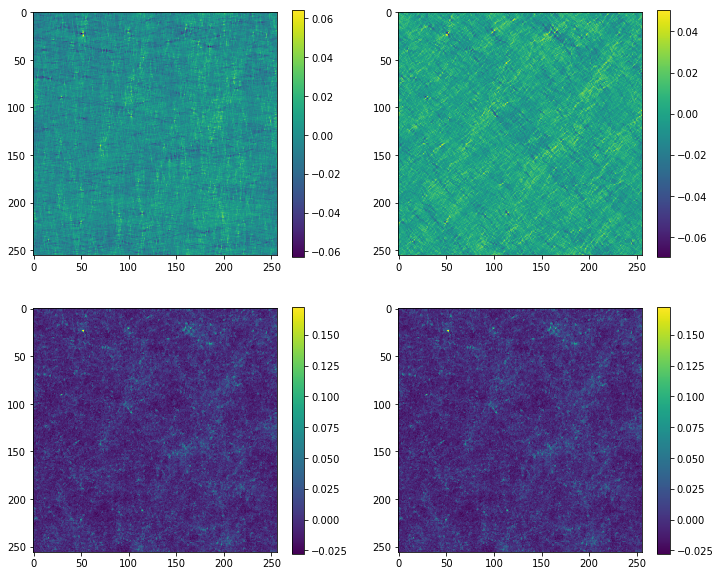

In [13]:
_ = plt.figure(figsize =(12,10))
_ = plt.subplot(2,2,1)
_ = plt.imshow(g1), plt.colorbar()
_ = plt.subplot(2,2,2)
_ = plt.imshow(g2), plt.colorbar()
_ = plt.subplot(2,2,3)
_ = plt.imshow(patch_test.real), plt.colorbar()
_ = plt.subplot(2,2,4)
_ = plt.imshow(patch), plt.colorbar()

# Add mask and noise

In [ ]:
input_file_des = '../mice_mock/cat_DES_SV_zmean_final.fits'
hdu_des =  fits.open(input_file_des)
print(hdu_des.info())
des_cat = hdu_des[1].data
print(des_cat.columns)

In [ ]:
des_galaxy_shapes = np.concatenate([des_cat.field('e1_gal_sens'),des_cat.field('e2_gal_sens')])
std_e1 = np.std(des_galaxy_shapes)
_ = plt.hist(np.concatenate([des_cat.field('e1_gal_sens'),des_cat.field('e2_gal_sens')]),
             histtype='step', bins=np.linspace(-1,1,22))
title = str('std=' + str(std_e1)[:6])
_ = plt.title(title), plt.grid('True')

In [ ]:
pixels= hp.ang2pix(reduced_nside,theta = 0.5*np.pi - np.deg2rad(des_cat.field('dec_gal')),
                   phi = np.deg2rad(des_cat.field('ra_gal')))
count_map = np.bincount(pixels, minlength = hp.nside2npix(reduced_nside))
count_gnomview= hp.gnomview(count_map, rot=[+75.0,-52.5],  title='Mask', 
                min = 0, max=50, reso=4.5, xsize=256, ysize=256, flip ='geo', return_projected_map =True)


In [ ]:
sv_mask = np.where(count_gnomview<1,0.,1.)

In [ ]:
plt.imshow(sv_mask, origin = 'lower')

In [ ]:
g1_masked = sv_mask*g1
g2_masked = sv_mask*g2

In [ ]:
_ = plt.figure(figsize =(12,5))
_ = plt.subplot(1,2,1)
_ = plt.imshow(g1_masked, origin='lower'), plt.colorbar()
_ = plt.subplot(1,2,2)
_ = plt.imshow(g2_masked, origin='lower'), plt.colorbar()

In [ ]:
e1_des_noise, e2_des_noise = shape_noise_realisation(des_cat.field('ra_gal'),
                                                     des_cat.field('dec_gal'),
                                                     des_cat.field('e1_gal_sens'),
                                                     des_cat.field('e2_gal_sens'),
                                                     reduced_nside)


In [ ]:
e1_noise_map = hp.gnomview(e1_des_noise, rot=[+75.0,-52.5],  title='Mask', 
                min = -.2, max=.2, reso=4.5, xsize=256, ysize=256, flip ='geo', return_projected_map =True)
_ = plt.close()

e2_noise_map = hp.gnomview(e2_des_noise, rot=[+75.0,-52.5],  title='Mask', 
                min = -.2, max=.2, reso=4.5, xsize=256, ysize=256, flip ='geo', return_projected_map =True)
_ = plt.close()

In [ ]:
_ = plt.figure(figsize =(12,5))
_ = plt.subplot(1,2,1)
_ = plt.imshow(e1_noise_map, origin='lower', clim = (-0.2,0.2)), plt.colorbar()
_ = plt.subplot(1,2,2)
_ = plt.imshow(e2_noise_map, origin='lower', clim = (-0.2,0.2)), plt.colorbar()

In [ ]:
e1_noisy = np.where(e1_noise_map.mask==False,  e1_noise_map + g1, 0.)
e2_noisy = np.where(e2_noise_map.mask==False,  e2_noise_map + g2, 0.)

In [ ]:
_ = plt.figure(figsize =(12,5))
_ = plt.subplot(1,2,1)
_ = plt.imshow(e1_noisy, origin='lower', clim = (-0.2,0.2)), plt.colorbar()
_ = plt.subplot(1,2,2)
_ = plt.imshow(e2_noisy, origin='lower', clim = (-0.2,0.2)), plt.colorbar()

# Try KS

In [ ]:
ks_ft = A_inverse_ft_diagonal * (np.fft.fft2(e1_noisy + 1j*e2_noisy).flatten())

In [ ]:
ks_test = np.fft.ifft2(np.reshape(ks_ft, patch.shape))

In [ ]:
ks_test.real.min()

In [ ]:
_ = plt.figure(figsize =(12,5))
_ = plt.subplot(1,2,1)
_ = plt.imshow(ks_test.real, origin='lower', clim = (-0.1,0.1)), plt.colorbar()
_ = plt.subplot(1,2,2)
_ = plt.imshow(ks_test.imag, origin='lower', clim = (-0.1,0.1)), plt.colorbar()

In [ ]:
ks_smoothed_e = ndimage.gaussian_filter(ks_test.real, sigma=2.)
ks_smoothed_b = ndimage.gaussian_filter(ks_test.imag, sigma=2.)
patch_smoothed = ndimage.gaussian_filter(patch, sigma=2.)

smoothed_truth = ndimage.gaussian_filter(patch.real, sigma=0.5)


In [ ]:
_ = plt.figure(figsize =(12,5))
_ = plt.subplot(1,2,1)
_ = plt.imshow(ks_smoothed_e, origin='lower'), plt.colorbar()
_ = plt.subplot(1,2,2)
_ = plt.imshow(ks_smoothed_b, origin='lower'), plt.colorbar()

In [ ]:
_ = plt.figure(figsize =(12,5))
_ = plt.subplot(1,2,1)
_ = plt.imshow(ks_smoothed_e*sv_mask, origin='lower'), plt.colorbar()
_ = plt.subplot(1,2,2)
_ = plt.imshow(smoothed_truth*sv_mask, origin='lower', interpolation='none'), plt.colorbar()

# Wiener filter step

In [ ]:
# compute the power spectrum 
fft2D = np.fft.fft2(patch.real)
psd1D_kmt = radial_profile(np.fft.fftshift(np.real(fft2D*np.conj(fft2D))))
ps_map_empirical = compute_spectrum_map(psd1D_kmt,256)

In [ ]:
ps_map_empirical.shape

In [ ]:
_ = plt.plot(ps_map_empirical.flatten()), plt.yscale('log')

In [ ]:
Ncov = np.where(count_gnomview>0.0, 2.0 * std_e1 * std_e1 / count_gnomview, 1e18)

In [ ]:
plt.imshow(Ncov, clim = (0,.02), origin='lower'), plt.colorbar()

In [ ]:
plt.loglog(psd1D_kmt)

In [ ]:
wiener_result500, wiener_b = prox_wiener_filtering(e1_noisy, e2_noisy, ps_map_empirical, Ncov)
wiener_result50, wiener_b = prox_wiener_filtering(e1_noisy, e2_noisy, ps_map_empirical, Ncov, 50)
wiener_result5, wiener_b = prox_wiener_filtering(e1_noisy, e2_noisy, ps_map_empirical, Ncov, 5)

In [ ]:
_ = plt.figure(figsize =(12,5))
_ = plt.subplot(1,2,1)
_ = plt.imshow(patch*sv_mask, origin='lower', vmin = -0.02,  vmax = 0.02, cmap = 'inferno'), plt.colorbar()
_ = plt.subplot(1,2,2)
_ = plt.imshow(wiener_result500*sv_mask, origin='lower', vmin = -0.02, vmax = 0.02, cmap = 'inferno'), plt.colorbar()

In [ ]:
_ = plt.figure(figsize =(12,5))
_ = plt.subplot(1,2,1)
_ = plt.imshow(wiener_result50*sv_mask, origin='lower', vmax = 0.02), plt.colorbar()
_ = plt.subplot(1,2,2)
_ = plt.imshow(wiener_result500*sv_mask, origin='lower', vmax = 0.02), plt.colorbar()

In [ ]:
_ = plt.figure(figsize =(12,5))
_ = plt.subplot(1,2,1)
_ = plt.imshow((wiener_result50 - wiener_result500)*sv_mask/(wiener_result500), origin='lower', clim=(-1,1)), plt.colorbar()
_ = plt.subplot(1,2,2)
_ = plt.imshow((wiener_result5  - wiener_result500)*sv_mask/(wiener_result500), origin='lower', clim=(-1,1)), plt.colorbar()


# Make a function do everything

In [ ]:
def generate_sv_maps(healpix_fits_file, data_file, output_base, n_outputs, power, Ncov, mask=None, fast_noise=True):
    
    nside = 1024
    kappa_map = hp.read_map(healpix_fits_file)
    
    if mask is None:
        print('mask calc')
        mask=np.zeros(hp.nside2npix(nside))
        th,ph=hp.pix2ang(nside,np.arange(hp.nside2npix(nside)))
        ph[np.where(ph>np.pi)[0]]-=2*np.pi
        mask[np.where((th<np.pi*0.5) & (ph>0) & (ph<np.pi*0.5))[0]]=1.
        
    kappa_map = np.where(mask>0.5, kappa_map, hp.UNSEEN)
    
    # make shear to kappa operator and KS
    k_modes = fftpack.fftfreq(256,256)
    k1_grid = np.dstack(np.meshgrid(k_modes, k_modes))[:,:,0]
    k2_grid = k1_grid.T 

    k1_vector = np.reshape(k1_grid, -1)
    k2_vector = np.reshape(k2_grid, -1)

    k_squared = k1_vector*k1_vector + k2_vector*k2_vector
    k_squared2 = np.where(k_squared==0, 1e-18, k_squared)

    A_ft_diagonal = (k1_vector**2 - k2_vector**2 + 1j*2.0*k1_vector*k2_vector)/k_squared2
    A_ft_diagonal = np.where(k_squared!=0.0, A_ft_diagonal, 1.0)

    A_inverse_ft_diagonal = (k1_vector**2 - k2_vector**2 - 1j*2.0*k1_vector*k2_vector)/k_squared2
    A_inverse_ft_diagonal = np.where(k_squared!=0.0, A_inverse_ft_diagonal, 1.0)
    
    
    # read in data
    hdu_data =  fits.open(data_file)
    data_cat = hdu_data[1].data
    
    if fast_noise==True:
        pixels= hp.ang2pix(reduced_nside,theta = 0.5*np.pi - np.deg2rad(des_cat.field('dec_gal')),
                   phi = np.deg2rad(des_cat.field('ra_gal')))
        count_map = np.bincount(pixels, minlength = hp.nside2npix(reduced_nside))

            
        count_gnomview= hp.gnomview(count_map, rot=[+75.0,-52.5],  title='Mask',
                                min = 0, max=50, reso=4.5, xsize=256, ysize=256,
                                flip ='geo', return_projected_map =True)
        _ = plt.close()
            
        std_map = np.where(count_gnomview>0, 0.25/np.sqrt(count_gnomview), 0.)
    
    output_kappa_array = np.empty((n_outputs, 256, 256, 1), dtype = np.float32)
    output_ks_array = np.empty((n_outputs, 256, 256, 1), dtype = np.float32)
    output_wiener_array = np.empty((n_outputs, 256, 256, 1), dtype = np.float32)
    output_shear_array = np.empty((n_outputs, 256, 256, 1), dtype = np.complex64)
    
    t= time.time()
    for i in range(n_outputs):
        
        if i%100==0:
            print(str(i))
        patch = random_map(kappa_map)
        
        
        shear_ft = A_ft_diagonal * (np.fft.fft2(patch).flatten())

        shear = np.fft.ifft2(np.reshape(shear_ft, patch.shape))

        g1 = shear.real
        g2 = shear.imag
        
        
        
        if fast_noise==True:
            e1_noise_map = np.random.normal(0.0, std_map)
            e2_noise_map = np.random.normal(0.0, std_map)

            e1_noisy = np.where(std_map!=0.,  e1_noise_map + g1, 0.)
            e2_noisy = np.where(std_map!=0.,  e2_noise_map + g2, 0.)
        
            
        else:
            e1_des_noise, e2_des_noise = shape_noise_realisation(data_cat.field('ra_gal'),
                                                                 data_cat.field('dec_gal'),
                                                                 data_cat.field('e1_gal_sens'),
                                                                 data_cat.field('e2_gal_sens'),
                                                                 nside)
            e1_noise_map = hp.gnomview(e1_des_noise, rot=[+75.0,-52.5],  title='Mask', 
                min = -.2, max=.2, reso=4.5, xsize=256, ysize=256, flip ='geo', return_projected_map =True)
            _ = plt.close()

            e2_noise_map = hp.gnomview(e2_des_noise, rot=[+75.0,-52.5],  title='Mask', 
                min = -.2, max=.2, reso=4.5, xsize=256, ysize=256, flip ='geo', return_projected_map =True)
            _ = plt.close()


            e1_noisy = np.where(e1_noise_map.mask==False,  e1_noise_map + g1, 0.)
            e2_noisy = np.where(e2_noise_map.mask==False,  e2_noise_map + g2, 0.)
        
        
        
        ks_ft = A_inverse_ft_diagonal * (np.fft.fft2(e1_noisy + 1j*e2_noisy).flatten())
        
        output_kappa_array[i,:,:,0] = np.array(patch)
        output_ks_array[i,:,:,0] = np.array(np.fft.ifft2(np.reshape(ks_ft, patch.shape))).real
        output_shear_array[i,:,:,0] = np.array(e1_noisy+ 1j*e2_noisy)
#         print(time.time())
        output_wiener_array[i,:,:,0], foo = prox_wiener_filtering(e1_noisy, e2_noisy, power, Ncov, n_iter=2)
#         print(time.time())
        
    print('\n' + 'saving outputs \n')
    np.save(str(output_base + '_kappa_true'), output_kappa_array)
#     np.save(str(output_base + '_noisy_shear'), output_shear_array)
    np.save(str(output_base + '_KS'), output_ks_array)
    np.save(str(output_base + '_wiener'), output_wiener_array)
        


In [ ]:
t = time.time()
generate_sv_maps('picola_training/kappa3_rescaled.fits',
                 'mice_mock/cat_DES_SV_zmean_final.fits',
                 'picola_training/test_outputs/output3',
                 n_outputs = 7500, power = ps_map_empirical, Ncov=Ncov)

print(time.time() -t)

In [ ]:
t = time.time()
generate_sv_maps('picola_training/kappa2_rescaled.fits',
                 'mice_mock/cat_DES_SV_zmean_final.fits',
                 'picola_training/test_outputs/output2',
                 n_outputs = 7500, power = ps_map_empirical, Ncov=Ncov)

print(time.time() -t)

In [ ]:
test_ks = np.load('picola_training/test_outputs/output_KS.npy')
test_true = np.load('picola_training/test_outputs/output_kappa_true.npy')
# test_shear = np.load('picola_training/test_outputs/output_noisy_shear.npy')
test_wiener = np.load('picola_training/test_outputs/output_wiener.npy')

In [ ]:
test_set_wiener = np.load('picola_training/test_outputs/output_wiener_test500.npy')

In [ ]:
x = np.where(np.sum(test_ks[:,:,:,:] , axis = (1,2,3)) < -1e20)
mask_bad_data = np.ones(test_ks[:,0,0,0].shape,dtype=np.bool)
mask_bad_data[x] = False

In [ ]:
n = 4  # how many images displayed

plt.figure(figsize=(20, 20))
for i in range(n):
    # display original
    plt.subplot(4, n, i + 1)
    
    plt.imshow(test_true[i,:,:,0], origin = 'lower', cmap = 'inferno', clim= (-0.03,0.04))
    plt.axis('off'), plt.colorbar(fraction=0.046, pad=0.04)
    
    plt.subplot(4, n, i + 1 + n)
    plt.imshow(test_true[i,:,:,0]*sv_mask, origin = 'lower', cmap = 'inferno', clim= (-0.03,0.04))
    plt.axis('off'), plt.colorbar(fraction=0.046, pad=0.04)
    
    plt.subplot(4, n, i + 1 + 2*n)
    plt.imshow(test_ks[i,:,:,0], cmap = 'inferno', origin = 'lower', clim= (-0.2,0.2))
    plt.axis('off'), plt.colorbar(fraction=0.046, pad=0.04)
    
    plt.subplot(4, n, i + 1 + 3*n)
    plt.imshow(test_wiener[i,:,:,0], cmap = 'inferno', origin = 'lower', clim= (-0.02,0.02))
    plt.axis('off'), plt.colorbar(fraction=0.046, pad=0.04)
    

plt.savefig('picola_training_data.pdf')
plt.show()

In [ ]:
n = 4  # how many images displayed

plt.figure(figsize=(20, 20))
for i in range(n):
    # display original
    plt.subplot(4, n, i + 1)
    
    plt.imshow(mf.rescale_map(test_true[i,:,:,0], 1.0, 0.5), origin = 'lower', cmap = 'inferno')
    plt.axis('off'), plt.colorbar(fraction=0.046, pad=0.04)
    
    plt.subplot(4, n, i + 1 + n)
    plt.imshow(mf.rescale_map(test_true[i,:,:,0]*sv_mask, 1.0, 0.5), origin = 'lower', cmap = 'inferno')
    plt.axis('off'), plt.colorbar(fraction=0.046, pad=0.04)
    
    plt.subplot(4, n, i + 1 + 2*n)
    plt.imshow(mf.rescale_map(test_ks[i,:,:,0], 1., 0.5), cmap = 'inferno', origin = 'lower')
    plt.axis('off'), plt.colorbar(fraction=0.046, pad=0.04)
    
    plt.subplot(4, n, i + 1 + 3*n)
    plt.imshow(mf.rescale_map(test_wiener[i,:,:,0], 1., 0.5), cmap = 'inferno', origin = 'lower')
    plt.axis('off'), plt.colorbar(fraction=0.046, pad=0.04)
    

plt.show()